# Model 

In [229]:
import numpy as np
import pandas as pd
import torch
from torch.nn import Linear, Module, Parameter, ReLU, Sequential, LeakyReLU, Dropout, BatchNorm1d
from torch.nn.functional import cross_entropy
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import wandb
from data_transformer.data_transformer import DataTransformer
from data_analyse.preprocessing import DataPreprocessor
from sklearn.decomposition import PCA
from data_analyse.analyse import DataAnalyzer
import os
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
class Encoder(Module):
    def __init__(self, data_dim, compress_dims, latent_dim):
        super().__init__()
        dim = data_dim
        seq = []
        for item in list(compress_dims):
            seq += [Linear(dim, item), BatchNorm1d(item), LeakyReLU(), Dropout()]
            dim = item

        self.seq = Sequential(*seq)
        self.fc1 = Linear(dim, latent_dim)
        self.fc2 = Linear(dim, latent_dim)

    def forward(self, input_):
        feature = self.seq(input_)
        mu = self.fc1(feature)
        logvar = self.fc2(feature)
        std = torch.exp(0.5 * logvar)
        return mu, std, logvar


class Decoder(Module):
    def __init__(self, latent_dim, decompress_dims, data_dim):
        super(Decoder, self).__init__()
        dim = latent_dim
        seq = []
        for item in list(decompress_dims):
            seq += [Linear(dim, item),  BatchNorm1d(item), LeakyReLU(), Dropout()]
            dim = item

        seq.append(Linear(dim, data_dim))
        self.seq = Sequential(*seq)
        self.sigma = Parameter(torch.ones(data_dim) * 0.1)

    def forward(self, input_):
        return self.seq(input_), self.sigma


def _loss_function(recon_x, x, sigmas, mu, logvar, output_info):
    st = 0
    loss = []
    for column_info in output_info:
        for span_info in column_info:
            if span_info.activation_fn != 'softmax':
                ed = st + span_info.dim
                std = sigmas[st]
                eq = x[:, st] - torch.tanh(recon_x[:, st])
                loss.append((eq**2 / 2 / (std**2)).sum())
                loss.append(torch.log(std) * x.size()[0])
                st = ed

            else:
                ed = st + span_info.dim
                loss.append(
                    cross_entropy(
                        recon_x[:, st:ed], torch.argmax(x[:, st:ed], dim=-1), reduction='sum'
                    )
                )
                st = ed

    assert st == recon_x.size()[1]
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    return sum(loss)  / x.size()[0], KLD / x.size()[0]


class CTVAE():

    def __init__(
        self,
        latent_dim=128,
        compress_dims=(128, 128),
        decompress_dims=(128, 128),
        l2scale=1e-5,
        batch_size=500,
        epochs=300,
        loss_factor=2,
        cuda=True,
        verbose=False,
        track = False
    ):
        self.latent_dim = latent_dim
        self.compress_dims = compress_dims
        self.decompress_dims = decompress_dims
        self.encoder = None
        self.decoder = None
        self.l2scale = l2scale
        self.batch_size = batch_size
        self.loss_factor = loss_factor
        self.epochs = epochs
        self.verbose = verbose
        self.track = track
        self.transformer = None
        if not cuda or not torch.cuda.is_available():
            device = 'cpu'
        elif isinstance(cuda, str):
            device = cuda
        else:
            device = 'cuda'

        self._device = torch.device(device)
 
    def fit(self, train_data, discrete_columns=(), val_split=0.2, early_stopping_patience=20, early_stopping_delta=0.001, lr = 0.001, patience_beta = None):
        if self.track:
            wandb.init(project="Data Augmentation - CTVAE", name="CTVAE", config={
                "latent_dim": self.latent_dim,
                "compress_dims": self.compress_dims,
                "decompress_dims": self.decompress_dims,
                "l2scale": self.l2scale,
                "batch_size": self.batch_size,
                "epochs": self.epochs,
                "loss_factor": self.loss_factor,
                "val_split": val_split,
                "early_stopping_patience": early_stopping_patience,
                "early_stopping_delta": early_stopping_delta
            })
        self.transformer = DataTransformer()
        self.transformer.fit(train_data, discrete_columns)
        transformed_data = self.transformer.transform(train_data)
        
        data_size = len(transformed_data)
        indices = np.arange(data_size)
        np.random.shuffle(indices)
        
        val_size = int(data_size * val_split)
        train_indices = indices[val_size:]
        val_indices = indices[:val_size]
        
        train_data = transformed_data[train_indices]
        val_data = transformed_data[val_indices]
        
        train_dataset = TensorDataset(torch.from_numpy(train_data.astype('float32')).to(self._device))
        val_dataset = TensorDataset(torch.from_numpy(val_data.astype('float32')).to(self._device))
        
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=False)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, drop_last=False)
        
        data_dim = self.transformer.output_dimensions
        self.encoder = Encoder(data_dim, self.compress_dims, self.latent_dim).to(self._device)
        self.decoder = Decoder(self.latent_dim, self.decompress_dims, data_dim).to(self._device)
        
        optimizer = Adam(
            list(self.encoder.parameters()) + list(self.decoder.parameters()), 
            weight_decay=self.l2scale,
            lr=lr
        )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min',
            factor=0.5,    
            patience=5,     
            min_lr=1e-6   
        )
        best_val_loss = float('inf')
        early_stopping_counter = 0
        best_model_state = None

        if patience_beta:
            is_des = True
            loss_KL_val = []
            wait_beta = 0
        else:
            is_des = False
        for epoch in range(self.epochs):
            self.encoder.train()
            self.decoder.train()
            train_loss = 0
            train_loss1 = 0 
            train_loss2 = 0  
            batch_count = 0
            loss_KL_train_small = []
            for data in train_loader:
                optimizer.zero_grad()
                real = data[0].to(self._device)
                mu, std, logvar = self.encoder(real)
                eps = torch.randn_like(std)
                emb = eps * std + mu
                rec, sigmas = self.decoder(emb)
                loss_1, loss_2 = _loss_function(
                    rec,
                    real,
                    sigmas,
                    mu,
                    logvar,
                    self.transformer.output_info_list,
                )
                #loss_KL_train_small.append(loss_2)
                loss = loss_1 + loss_2*self.loss_factor
                loss.backward()
                optimizer.step()
                self.decoder.sigma.data.clamp_(0.01, 1.0)
                train_loss += loss.item()
                train_loss1 += loss_1.item()
                train_loss2 += loss_2.item()
                batch_count += 1
            avg_train_loss = train_loss / batch_count
            avg_train_loss1 = train_loss1 / batch_count
            avg_train_loss2 = train_loss2 / batch_count
            
            self.encoder.eval()
            self.decoder.eval()
            val_loss = 0
            val_loss1 = 0
            val_loss2 = 0
            batch_count = 0

                
            with torch.no_grad():
                for data in val_loader:
                    real = data[0].to(self._device)
                    mu, std, logvar = self.encoder(real)
                    eps = torch.randn_like(std)
                    emb = eps * std + mu
                    rec, sigmas = self.decoder(emb)
                    loss_1, loss_2 = _loss_function(
                        rec,
                        real,
                        sigmas,
                        mu,
                        logvar,
                        self.transformer.output_info_list,
                    )
                    loss = loss_1 + loss_2*self.loss_factor
                    val_loss += loss.item()
                    val_loss1 += loss_1.item()
                    val_loss2 += loss_2.item()
                    batch_count += 1
            
            avg_val_loss = val_loss / batch_count
            avg_val_loss1 = val_loss1 / batch_count
            avg_val_loss2 = val_loss2 / batch_count
            
            scheduler.step(avg_val_loss)
            if is_des:
                loss_KL_val.append(avg_train_loss2)
                if len(loss_KL_val) > 1:
                    if loss_KL_val[-1] > loss_KL_val[-2]:
                        if wait_beta >= patience_beta:
                            self.loss_factor = self.loss_factor*1.1
                            wait_beta = 0
                        else:
                            wait_beta += 1

            current_lr = optimizer.param_groups[0]['lr']
            if self.track :
                wandb.log({
                    "epoch": epoch,
                    "train_loss": avg_train_loss,
                    "train_reconstruction_loss": avg_train_loss1,
                    "train_kl_divergence_loss": avg_train_loss2,
                    "val_loss": avg_val_loss,
                    "val_reconstruction_loss": avg_val_loss1,
                    "val_kl_divergence_loss": avg_val_loss2,
                    "learning_rate": current_lr
                })
            if self.verbose :
                if epoch % 5 == 0 or epoch == self.epochs - 1:
                    print(f"Epoch {epoch}/{self.epochs} - "
                          f"Train Loss: {avg_train_loss:.4f} (Rec: {avg_train_loss1:.4f}, KL: {avg_train_loss2:.4f}), "
                          f"Val Loss: {avg_val_loss:.4f} (Rec: {avg_val_loss1:.4f}, KL: {avg_val_loss2:.4f}), "
                          f"LR: {current_lr:.6f}, "
                          f"Patient: {early_stopping_counter}/{early_stopping_patience} ")
            if avg_val_loss < best_val_loss - early_stopping_delta:
                best_val_loss = avg_val_loss
                early_stopping_counter = 0
                
                best_model_state = {
                    'encoder': self.encoder.state_dict(),
                    'decoder': self.decoder.state_dict(),
                    'epoch': epoch,
                    'val_loss': avg_val_loss
                }
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= early_stopping_patience:
                    print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.4f}")
                    if self.track:
                        wandb.log({"early_stopping": epoch})
                    if best_model_state:
                        self.encoder.load_state_dict(best_model_state['encoder'])
                        self.decoder.load_state_dict(best_model_state['decoder'])
                    
                    break

        if early_stopping_counter < early_stopping_patience and best_model_state:
            self.encoder.load_state_dict(best_model_state['encoder'])
            self.decoder.load_state_dict(best_model_state['decoder'])
        if self.track:
            wandb.finish()
    def sample(self, samples):
        self.decoder.eval()

        steps = samples // self.batch_size + 1
        data = []
        for _ in range(steps):
            mean = torch.zeros(self.batch_size, self.latent_dim)
            std = mean + 1
            noise = torch.normal(mean=mean, std=std).to(self._device)
            fake, sigmas = self.decoder(noise)
            fake = torch.tanh(fake)
            data.append(fake.detach().cpu().numpy())
        data = np.concatenate(data, axis=0)
        data = data[:samples]
        return self.transformer.inverse_transform(data, sigmas.detach().cpu().numpy())

    def set_device(self, device):
        """Set the `device` to be used ('GPU' or 'CPU)."""
        self._device = device
        self.decoder.to(self._device)
        
    def save(self):
        if self.encoder is None or self.decoder is None:
            raise RuntimeError("Model not trained. Call fit() first.")
        is_saved = False
        file_name = input("Tap model's name:" )
        while not is_saved:
            if os.path.exists(f"models/{file_name}.pth"):
                print("Model's name existes!!!!")
                file_name = input("Tap model's name:" )
            else:
                torch.save(self,f"models/{file_name}.pth")
                is_saved = True
                print("Done!!!!")
        return 1
    def load(self, file_name):
        model = torch.load(f"models/{file_name}.pth", map_location=self._device, weights_only=False)
        self.encoder = model.encoder
        self.decoder = model.decoder
        self.latent_dim = model.latent_dim
        self.compress_dims = model.compress_dims
        self.decompress_dims = model.decompress_dims
        self.transformer = model.transformer

        

# Preprocessing

In [286]:
data = pd.read_csv('data/DataModified.csv', sep=',')
cat_cols = ["CONFIG", "T", "EQUIPEMENT", "FREQUENCE"]
num_cols = ["DATA", "DELTA", "MESURE A", "MESURE A REF", "MESURE B"] 
preprocessor = DataPreprocessor(
        categorical_cols=cat_cols,
        numerical_cols=num_cols)
cleaned_data, cleaned_output = preprocessor.preprocess(data)

# Train using PCA

In [61]:
trainable_data_pca, pca = preprocessor.apply_pca(cleaned_data, cleaned_output, n_components= 23)

Information kept: 99.999514273%


In [581]:
ctvae = CTVAE(compress_dims= (32,32,24,16), decompress_dims= (16,24,32,32),latent_dim=16,track= True, verbose= True, loss_factor= 0.1,batch_size=300)
ctvae.fit(train_data= trainable_data, discrete_columns= cat_cols, lr= 0.01, patience_beta= 3)

Epoch 0/300 - Train Loss: 98.1261 (Rec: 96.0220, KL: 21.0407), Val Loss: 40.4112 (Rec: 40.3790, KL: 0.3223), LR: 0.010000, Patient: 0/20 
Epoch 5/300 - Train Loss: 35.8808 (Rec: 35.3658, KL: 5.1504), Val Loss: 35.1064 (Rec: 35.0482, KL: 0.5818), LR: 0.010000, Patient: 0/20 
Epoch 10/300 - Train Loss: 35.4432 (Rec: 35.0730, KL: 3.3655), Val Loss: 34.9903 (Rec: 34.9482, KL: 0.3828), LR: 0.010000, Patient: 0/20 
Epoch 15/300 - Train Loss: 35.1339 (Rec: 34.8762, KL: 2.3430), Val Loss: 34.9622 (Rec: 34.9313, KL: 0.2815), LR: 0.010000, Patient: 1/20 
Epoch 20/300 - Train Loss: 35.0184 (Rec: 34.8053, KL: 1.7616), Val Loss: 34.9376 (Rec: 34.9052, KL: 0.2679), LR: 0.010000, Patient: 2/20 
Epoch 25/300 - Train Loss: 34.9463 (Rec: 34.7521, KL: 1.6056), Val Loss: 34.8781 (Rec: 34.8472, KL: 0.2553), LR: 0.010000, Patient: 1/20 
Epoch 30/300 - Train Loss: 34.8505 (Rec: 34.6659, KL: 1.5260), Val Loss: 34.8578 (Rec: 34.8227, KL: 0.2895), LR: 0.010000, Patient: 4/20 
Epoch 35/300 - Train Loss: 34.7903 

early_stopping,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇████
learning_rate,██████████████████████████████████▄▂▂▁▁▁
train_kl_divergence_loss,█▅▄▃▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_reconstruction_loss,██▇▇▇▇▇▇▇▆▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_kl_divergence_loss,▁█▃▃▂▁▁▁▁▁▂▃▄▄▄▄▅▅▅▅▅▅▆▅▆▆▆▆▅▆▆▆▆▆▆▅▅▅▅▅
val_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_reconstruction_loss,█▅▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
early_stopping,158
epoch,158


In [585]:
ctvae.save()

Tap model's name: ctvae1


Model's name existes!!!!


Tap model's name: ctvae2


Model's name existes!!!!


Tap model's name: ctvae3


Model's name existes!!!!


Tap model's name: ctvae1


Done!!!!


1

In [637]:
output_inverse[0].shape

(1000, 101)

In [645]:
synthetic_data

,DATA,CONFIG,T,EQUIPEMENT,DELTA,MESURE A,MESURE A REF,MESURE B,FREQUENCE,comp_1,...,comp_14,comp_15,comp_16,comp_17,comp_18,comp_19,comp_20,comp_21,comp_22,comp_23
0,86,-2.0,11,1,1.166128,-0.010485,-0.050418,3.878750,1,-5.445733,...,-0.049195,-0.192462,0.033910,-0.012780,-0.010440,-0.058410,0.089294,-0.042825,0.076586,-0.023179
1,162,0.0,6,1,1.073123,-1.000136,-0.836750,1.815613,4,-1.631595,...,0.153283,0.096480,0.036130,-0.019982,0.140022,-0.087243,-0.010961,-0.010527,0.004532,-0.020375
2,143,0.0,6,1,-0.179520,-0.671217,-0.786199,1.271708,3,-23.623063,...,-0.233983,0.018595,0.047977,-0.033430,-0.028356,0.078853,-0.010099,-0.019689,-0.029090,-0.039926
3,175,0.0,6,1,-1.273126,-0.934415,-0.767609,1.048476,4,-6.529996,...,0.114491,0.109167,0.053916,-0.037384,0.207367,-0.050026,0.038752,-0.000936,-0.036656,-0.042857
4,199,0.0,6,1,-0.692311,-0.787805,-0.810914,2.063229,3,-24.014073,...,-0.124763,0.016643,0.035645,-0.035626,-0.015167,0.063292,-0.031337,-0.001073,-0.018343,-0.020132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,169,0.0,11,1,0.463911,-0.965309,-0.764395,1.263062,3,16.530118,...,-0.142169,-0.058394,-0.010160,-0.003846,-0.017235,0.072133,-0.019962,-0.028072,-0.001441,-0.039817
996,67,0.0,11,1,1.249494,0.031016,0.057822,3.926607,1,-4.550195,...,-0.061306,-0.208239,0.093046,0.076876,-0.045937,0.131577,-0.009673,-0.015499,0.085909,0.006034
997,59,0.0,11,1,-1.288686,0.082741,-0.088556,4.386406,3,6.572035,...,-0.154338,-0.222973,0.070932,0.089484,-0.018388,0.094023,-0.088702,-0.016891,0.047490,0.003061
998,63,-2.0,11,1,0.228444,0.021981,-0.062580,3.924037,1,-2.716346,...,-0.076782,-0.252878,0.056310,0.014775,-0.046321,0.106636,-0.057329,-0.013463,0.051653,-0.003015


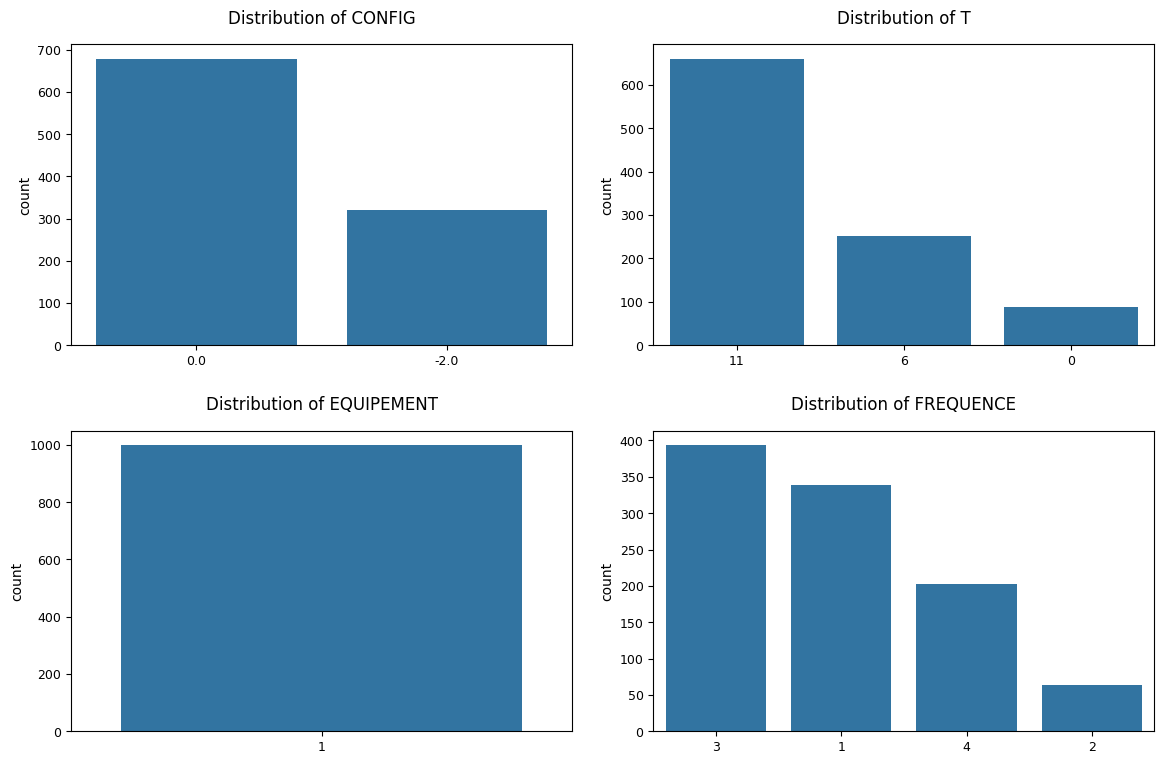

In [647]:
n = 1000
synthetic_data = ctvae.sample(n)
output_inverse = pca.inverse_transform([synthetic_data.iloc[:,9:]])
output_inverse = pd.DataFrame(output_inverse[0], columns=[f'OUTPUT_{i}' for i in range(101)])
synthetic_data = pd.concat([synthetic_data.iloc[:,:9], output_inverse], axis=1)

analyzer = DataAnalyzer(synthetic_data, numeric_columns = num_cols, categorical_columns= cat_cols)
cat_plot = analyzer.plot_distributions_cat()

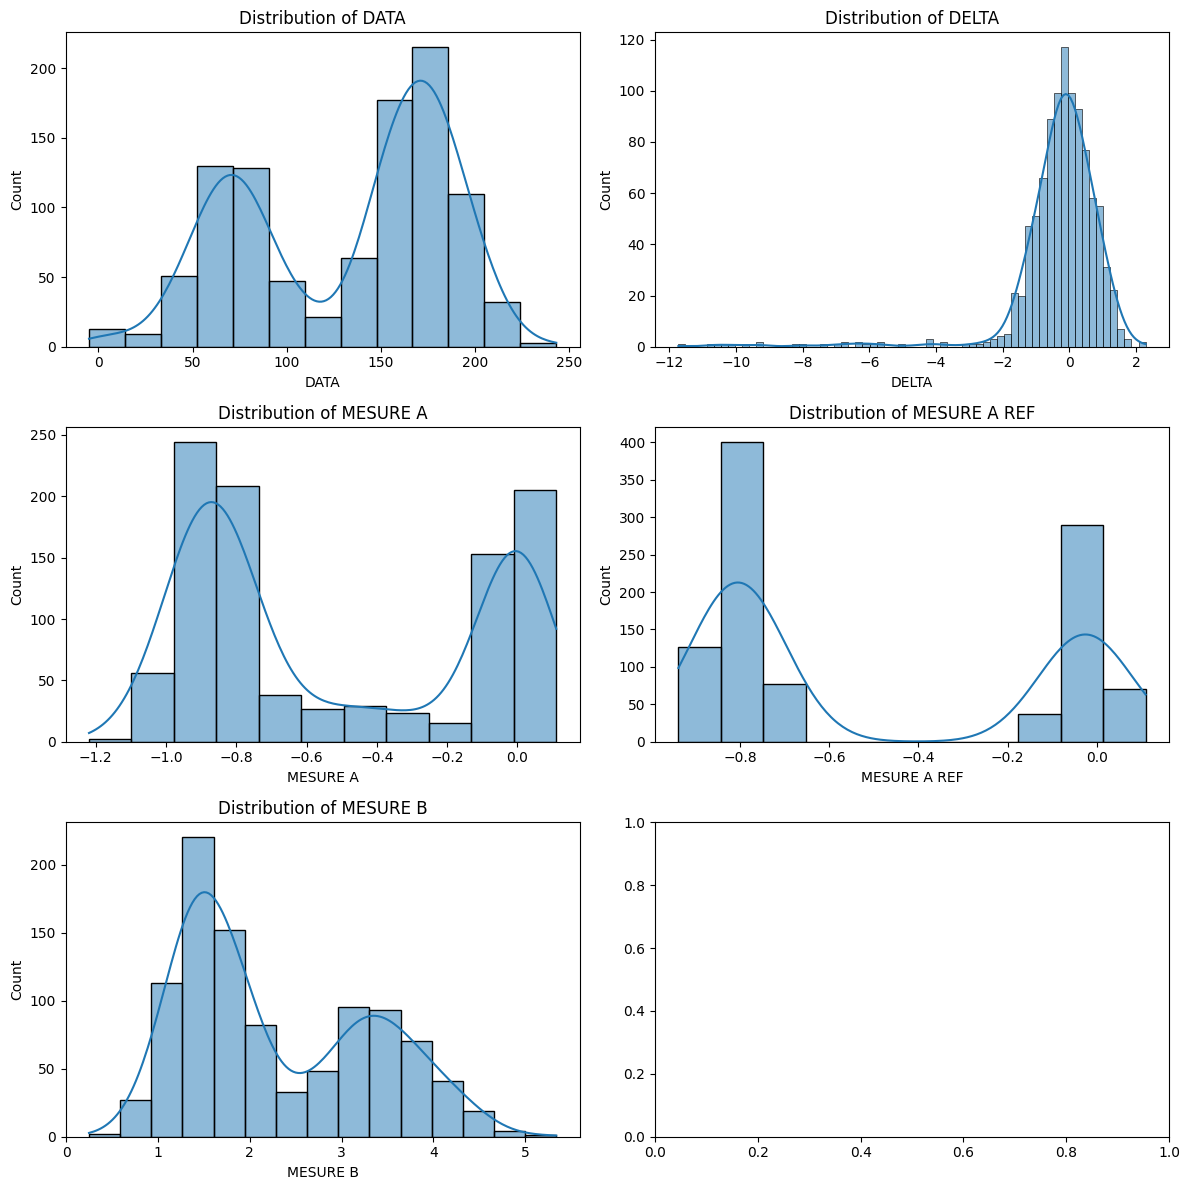

In [653]:
dis_plot = analyzer.plot_distributions()

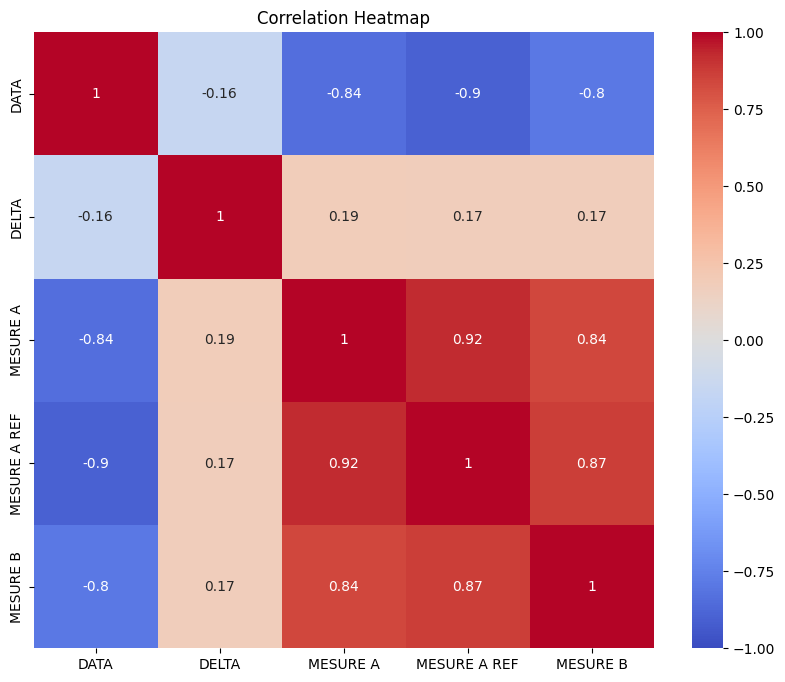

In [655]:
heat_map = analyzer.plot_correlation_heatmap()

In [379]:
trainable_data.describe()

,DATA,CONFIG,T,EQUIPEMENT,DELTA,MESURE A,MESURE A REF,MESURE B,FREQUENCE,comp_1,...,comp_14,comp_15,comp_16,comp_17,comp_18,comp_19,comp_20,comp_21,comp_22,comp_23
count,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5543.000000,5.543000e+03,...,5.543000e+03,5.543000e+03,5.543000e+03,5.543000e+03,5.543000e+03,5.543000e+03,5.543000e+03,5.543000e+03,5.543000e+03,5.543000e+03
mean,94.411690,-0.346202,7.972398,3.462024,1.785134,-0.768081,-0.633058,2.360333,2.647664,-1.427495e-14,...,-1.100361e-14,-5.994043e-15,-2.045807e-14,7.606961e-15,4.071232e-15,-1.992897e-14,3.636035e-15,-1.276971e-14,-4.673712e-15,1.062834e-14
std,66.956751,0.990403,5.510116,2.182976,37.356440,0.783579,0.560249,1.666710,1.326172,5.645088e+01,...,1.401034e-01,1.176415e-01,1.026730e-01,8.758003e-02,8.178654e-02,7.134210e-02,6.510305e-02,5.090936e-02,4.729508e-02,4.400178e-02
min,0.000000,-2.000000,0.000000,1.000000,-131.000000,-7.673330,-6.049308,-5.529413,1.000000,-2.064887e+03,...,-8.648409e-01,-5.345528e-01,-6.318912e-01,-5.282316e-01,-6.626907e-01,-4.913033e-01,-3.921056e-01,-2.444344e-01,-2.082732e-01,-2.543679e-01
25%,42.000000,-2.000000,6.000000,1.000000,-4.000000,-0.940182,-0.849914,1.358421,2.000000,-6.572154e+00,...,-9.568812e-02,-8.104702e-02,-6.221887e-02,-5.428643e-02,-5.559536e-02,-4.754475e-02,-4.516999e-02,-3.003708e-02,-3.143705e-02,-2.839708e-02
50%,88.000000,0.000000,6.000000,3.000000,0.000000,-0.764701,-0.773973,1.849031,3.000000,1.514152e+00,...,3.968857e-03,-1.691122e-03,3.276506e-03,-1.803650e-03,-1.860449e-02,-1.280279e-04,-9.899154e-04,-6.443411e-04,-2.175745e-03,-1.710069e-03
75%,142.000000,0.500000,11.000000,6.000000,0.000000,-0.249562,-0.242806,3.348815,4.000000,9.114449e+00,...,9.558688e-02,7.714185e-02,6.455617e-02,5.353276e-02,3.345294e-02,4.601058e-02,4.361823e-02,3.299326e-02,3.159126e-02,2.778458e-02
max,255.000000,0.500000,15.000000,7.000000,208.000000,0.000000,0.000000,11.580734,5.000000,6.569954e+01,...,6.302250e-01,7.122004e-01,6.943761e-01,6.601254e-01,2.859432e-01,3.455733e-01,2.502651e-01,4.050472e-01,2.506044e-01,2.297115e-01


In [577]:
synthetic_data.describe()

,DATA,CONFIG,T,EQUIPEMENT,DELTA,MESURE A,MESURE A REF,MESURE B,FREQUENCE,comp_1,...,comp_14,comp_15,comp_16,comp_17,comp_18,comp_19,comp_20,comp_21,comp_22,comp_23
count,1000.000000,1000.0,1000.00000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,132.529000,0.0,10.81000,1.0,-0.085712,-0.515927,-0.499785,2.243217,2.025000,1.503867,...,-0.134542,-0.040577,0.048372,-0.001856,-0.010452,-0.060736,-0.022898,-0.016423,0.008749,-0.025025
std,53.165663,0.0,0.95646,0.0,0.778155,0.420575,0.381394,1.029649,0.996679,10.860962,...,0.124091,0.117432,0.040507,0.048140,0.036723,0.032764,0.033685,0.020455,0.041505,0.021843
min,-6.000000,0.0,6.00000,1.0,-2.718082,-1.131810,-0.940562,0.357460,1.000000,-33.807219,...,-0.395123,-0.295330,-0.106488,-0.116884,-0.122394,-0.156460,-0.121107,-0.074246,-0.090907,-0.101894
25%,77.000000,0.0,11.00000,1.0,-0.616400,-0.877143,-0.815322,1.413458,1.000000,-5.721863,...,-0.215320,-0.144608,0.019763,-0.037089,-0.033746,-0.080491,-0.047187,-0.029819,-0.025424,-0.041245
50%,155.500000,0.0,11.00000,1.0,-0.092032,-0.774056,-0.753984,1.827861,3.000000,1.676517,...,-0.163199,-0.022870,0.049412,-0.006441,-0.014668,-0.062852,-0.023749,-0.017372,0.000565,-0.025405
75%,177.000000,0.0,11.00000,1.0,0.446583,-0.015946,-0.040101,3.173367,3.000000,9.047798,...,-0.097519,0.059124,0.077547,0.033806,0.007065,-0.045263,0.000914,-0.002542,0.046260,-0.009792
max,232.000000,0.0,11.00000,1.0,2.325843,0.160233,0.093809,4.958178,3.000000,36.229730,...,0.264143,0.204573,0.176070,0.135192,0.123459,0.141315,0.073693,0.054498,0.099395,0.049696


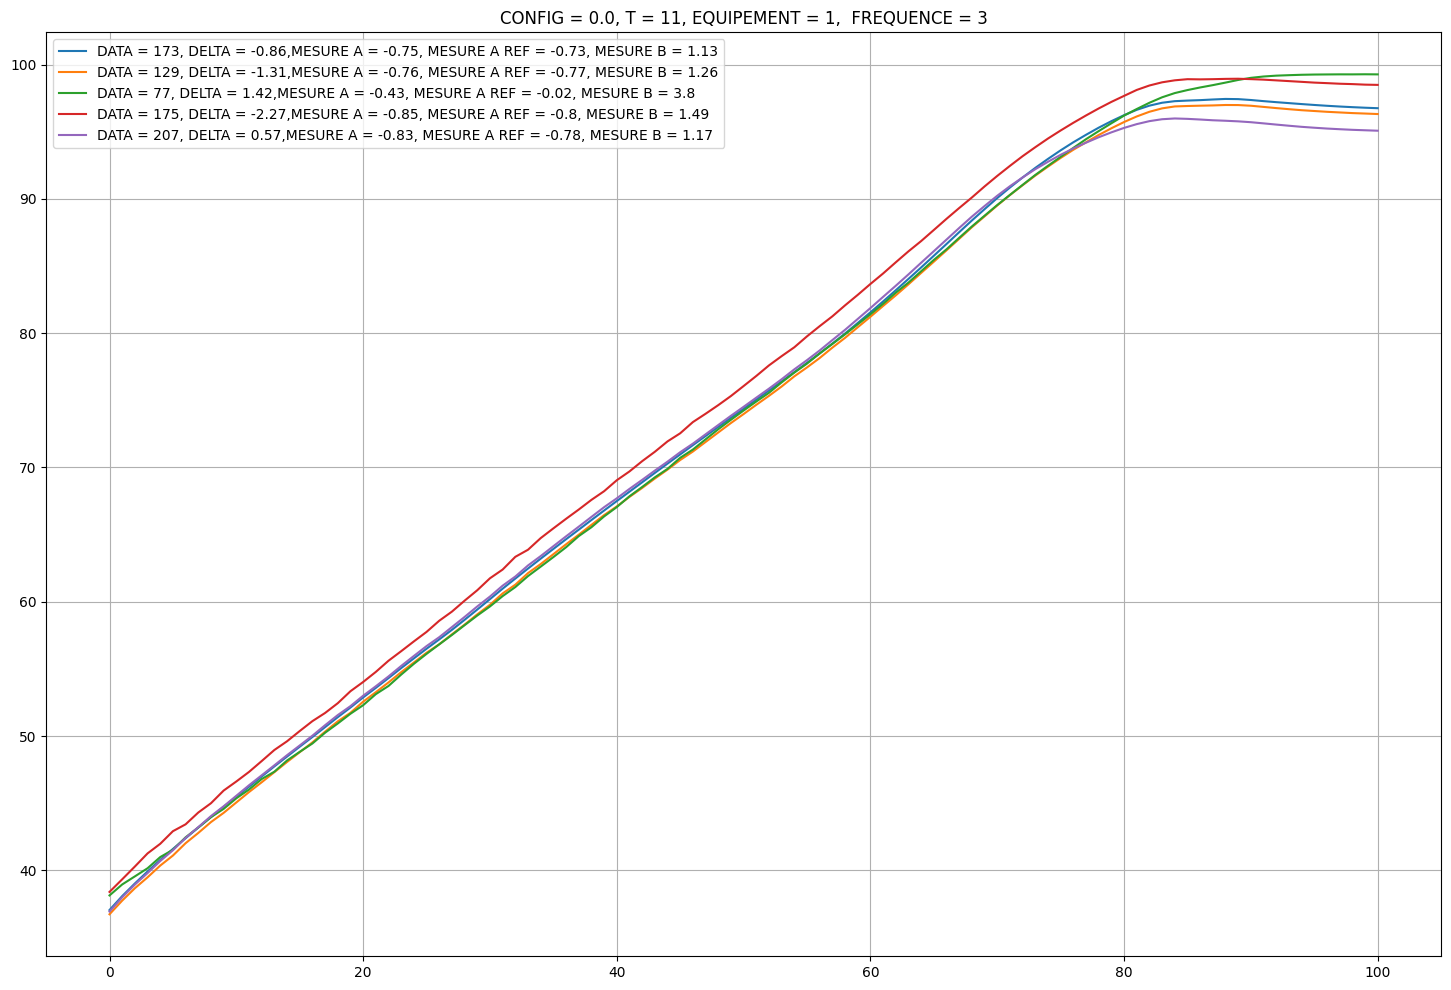

In [711]:
analyzer.plot_syn_data({
    "CONFIG" : 0,
    "T": 11,
    "EQUIPEMENT" : 1,
    "FREQUENCE" : 3
})

# Train using TWD

In [288]:
trainable_data_ondelette = preprocessor.apply_wavelet_transform(cleaned_data = cleaned_data,cleaned_output =  cleaned_output, wavelet = 'db4', level = 3)

In [258]:
ctvae = CTVAE(compress_dims= (64,32,24,16), decompress_dims= (16,24,32,64),latent_dim=16,track= True, verbose= True, loss_factor= 0.1,batch_size=300)
ctvae.fit(train_data= trainable_data_ondelette, discrete_columns= cat_cols, lr= 0.01, patience_beta= 3)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tuanhquanle (tuanhquanle-insa-toulouse) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch 0/300 - Train Loss: 449.1444 (Rec: 296.6602, KL: 1524.8425), Val Loss: 45.3746 (Rec: 44.9975, KL: 3.7712), LR: 0.010000, Patient: 0/20 
Epoch 5/300 - Train Loss: 10.8019 (Rec: 9.9344, KL: 8.6752), Val Loss: 8.3619 (Rec: 8.2403, KL: 1.2164), LR: 0.010000, Patient: 0/20 
Epoch 10/300 - Train Loss: 8.7976 (Rec: 7.6742, KL: 11.2340), Val Loss: 7.7669 (Rec: 7.6131, KL: 1.5383), LR: 0.010000, Patient: 0/20 
Epoch 15/300 - Train Loss: 6.9498 (Rec: 6.2183, KL: 6.6498), Val Loss: 7.1117 (Rec: 6.9494, KL: 1.4762), LR: 0.010000, Patient: 0/20 
Epoch 20/300 - Train Loss: 6.2240 (Rec: 5.2083, KL: 8.3937), Val Loss: 6.5545 (Rec: 6.3648, KL: 1.5677), LR: 0.010000, Patient: 0/20 
Epoch 25/300 - Train Loss: 4.6147 (Rec: 3.7456, KL: 6.5297), Val Loss: 4.0551 (Rec: 3.7757, KL: 2.0989), LR: 0.010000, Patient: 0/20 
Epoch 30/300 - Train Loss: 3.2853 (Rec: 2.1390, KL: 7.8293), Val Loss: 1.0303 (Rec: 0.5631, KL: 3.1911), LR: 0.010000, Patient: 0/20 
Epoch 35/300 - Train Loss: 1.2343 (Rec: 0.0383, KL: 8

early_stopping,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
learning_rate,█████████████████████████▄▄▄▄▄▄▄▄▄▄▃▂▁▁▁
train_kl_divergence_loss,▆▆█▅▅▄▅▅▆▆▆▆▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▅▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_reconstruction_loss,██▇▇▇▆▆▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_kl_divergence_loss,▁▁▁▂▂▂▂▂▂▂▃▄▄▅▅▆██▇▇▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃
val_loss,█▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_reconstruction_loss,█▃▃▃▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
early_stopping,111
epoch,111


In [ ]:
n = 1000
synthetic_data = ctvae.sample(n)
output_inverse = pca.inverse_transform([synthetic_data.iloc[:,9:]])
output_inverse = pd.DataFrame(output_inverse[0], columns=[f'OUTPUT_{i}' for i in range(101)])
synthetic_data = pd.concat([synthetic_data.iloc[:,:9], output_inverse], axis=1)

analyzer = DataAnalyzer(synthetic_data, numeric_columns = num_cols, categorical_columns= cat_cols)
cat_plot = analyzer.plot_distributions_cat()

In [260]:
n = 1000
synthetic_data = ctvae.sample(n)

In [262]:
synthetic_data

,DATA,CONFIG,T,EQUIPEMENT,DELTA,MESURE A,MESURE A REF,MESURE B,FREQUENCE,approx_0,...,detail_3_44,detail_3_45,detail_3_46,detail_3_47,detail_3_48,detail_3_49,detail_3_50,detail_3_51,detail_3_52,detail_3_53
0,82,0.0,6,1,-0.362127,0.024239,-0.040714,2.683812,3,119.032707,...,0.000661,-0.001374,-0.001918,0.000005,-0.001773,0.001565,-0.001888,-0.002148,-0.000193,0.000027
1,74,0.0,6,1,0.203395,0.010286,-0.045597,4.102949,3,113.289362,...,0.007337,-0.000486,-0.002900,-0.000096,-0.000533,-0.000327,0.000464,0.001861,0.000104,-0.001319
2,45,0.0,6,1,-1.303814,-0.015278,-0.028828,2.580614,3,117.720930,...,-0.001274,0.001826,0.001848,-0.000597,0.002384,0.000805,-0.002127,0.003152,-0.000802,0.000441
3,57,0.0,6,1,-0.203876,0.051472,-0.047859,2.929866,3,113.012865,...,0.003292,0.001282,-0.003747,0.001433,-0.001057,-0.001106,-0.000102,0.004799,-0.000239,0.000218
4,130,0.0,11,1,-1.554227,-0.840300,-0.821237,1.901125,4,114.486712,...,-0.004146,-0.001582,0.002832,0.001018,-0.002271,-0.000973,-0.004019,0.003286,0.000273,0.001464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,169,0.0,11,1,-0.460435,-0.917632,-0.758561,1.000954,3,117.719168,...,0.001768,0.003086,0.002834,0.000132,-0.002192,0.000737,-0.000018,0.001264,-0.000391,0.000576
996,127,0.0,11,1,-1.300947,-1.015762,-0.889181,1.017692,4,116.635658,...,0.002597,0.000182,0.001599,-0.001826,-0.001146,0.000825,-0.001724,0.003060,-0.002339,-0.000559
997,45,0.0,6,1,1.856328,0.059226,-0.016515,3.204109,3,116.955341,...,-0.001328,-0.000807,-0.001889,-0.001642,0.002145,0.000767,-0.003411,0.001886,-0.000877,-0.001043
998,100,0.0,6,1,0.881616,0.017699,-0.019351,2.760839,3,110.705429,...,-0.003969,0.000064,-0.002217,-0.000003,0.000024,0.001286,-0.002940,-0.000104,-0.001161,-0.001034


In [300]:
output_inverse = preprocessor.inverse_wavelet_transform(df_all_coeffs = synthetic_data.iloc[:,9:], original_shape = (n, cleaned_output.shape[1]), wavelet='db4', level = 3)

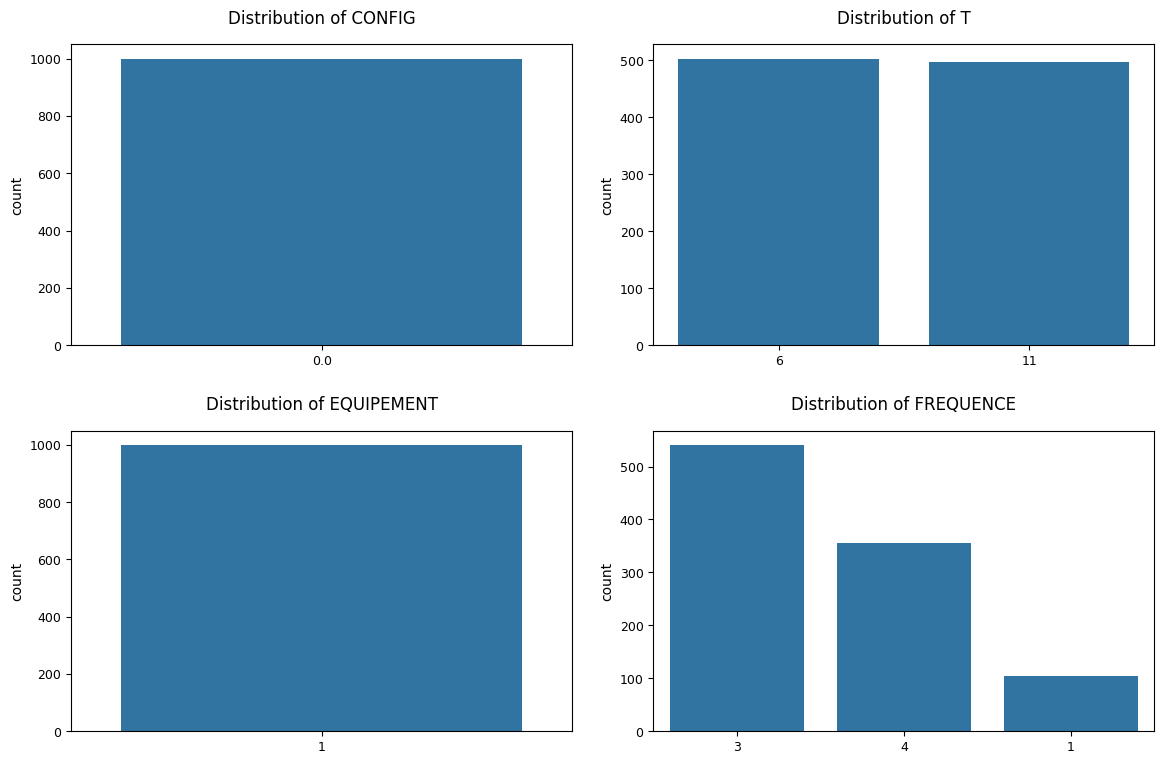

In [304]:
synthetic_data = pd.concat([synthetic_data.iloc[:,:9], output_inverse], axis=1)

analyzer = DataAnalyzer(synthetic_data, numeric_columns = num_cols, categorical_columns= cat_cols)
cat_plot = analyzer.plot_distributions_cat()

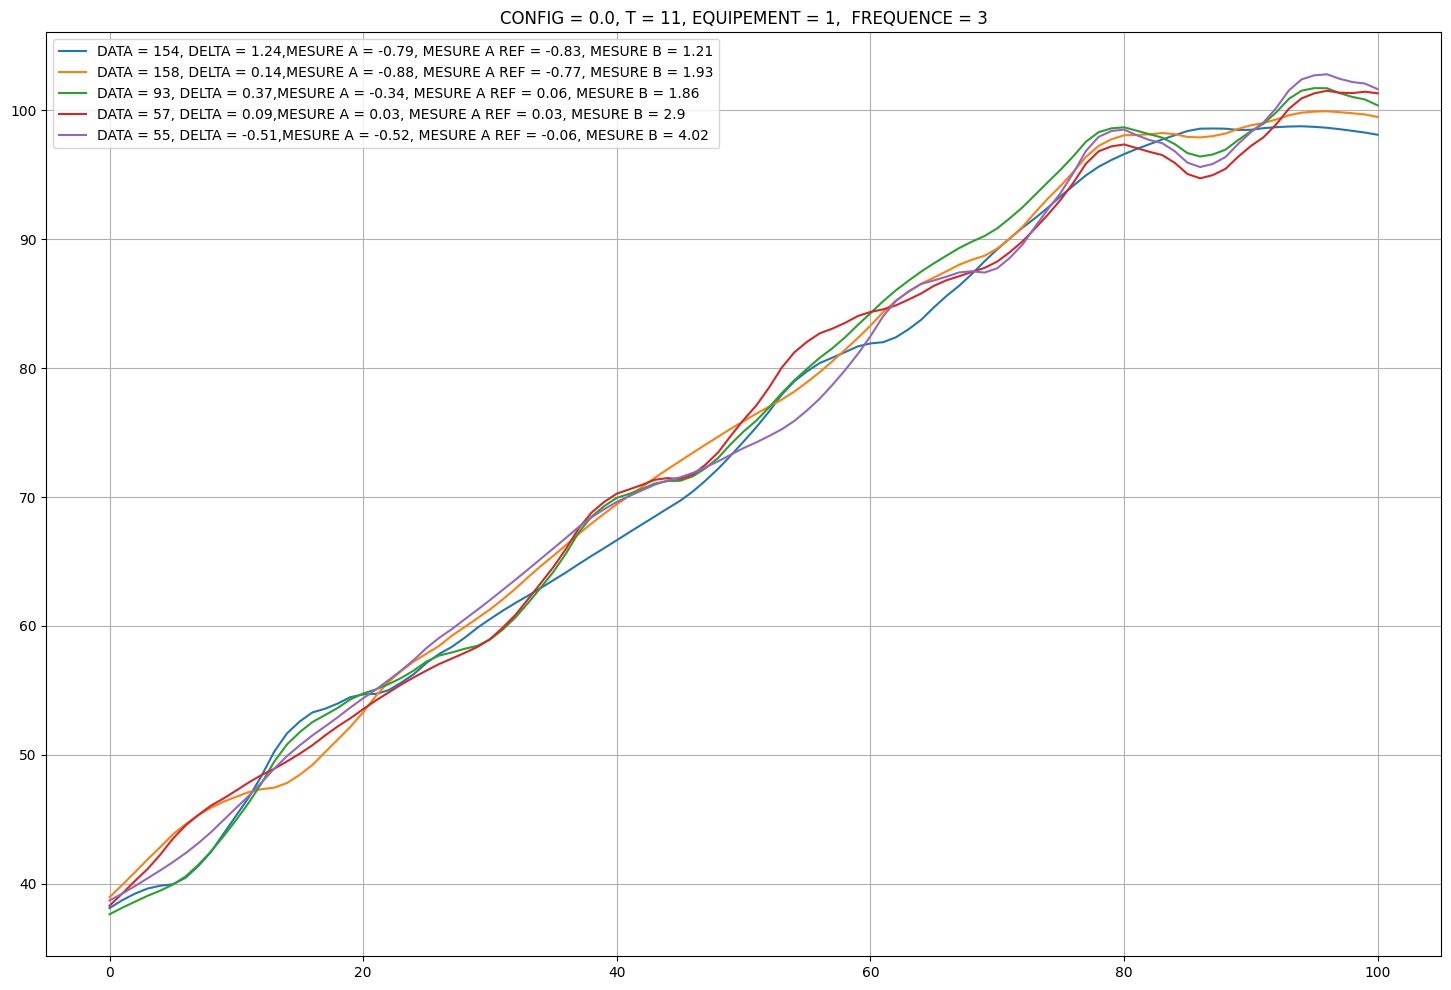

In [306]:
analyzer.plot_syn_data({
    "CONFIG" : 0,
    "T": 11,
    "EQUIPEMENT" : 1,
    "FREQUENCE" : 3
})